2.1 Gaussian Classifier

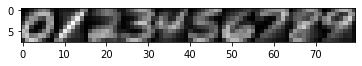

In [112]:
'''
Question 2.0 Skeleton Code

Here you should load the data and plot
the means for each of the digit classes.
'''

import data
import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt

def plot_means(train_data, train_labels):
    means = []
    for i in range(0, 10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)
        # Compute mean of class i
        # [0, 1, 0, 0, 1 ... ]in total 700 rows each with 64 columns
        i_digits = np.mean(i_digits, axis=0)
        means.append( i_digits.reshape((8,8)) )

    # Plot all means on same axis
    #print("means: ",means[0].shape)
    all_concat = np.concatenate(means, 1)
    plt.imshow(all_concat, cmap='gray')
    plt.show()

if __name__ == '__main__':
    train_data, train_labels, _, _ = data.load_all_data_from_zip('a4digits.zip', 'data')
    plot_means(train_data, train_labels)

2.1.1 Plot the log-diagonal of each covariance matrix side by side


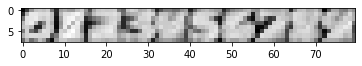

2.1.2 Compute the average conditional log-likelihood
For the training set:
The average conditional likelihood in the training set is: -0.12462443666863002
For the test set:
The average conditional likelihood in the test set is: -0.1966732032552562
2.1.3 Select the most likely posterior class for each training and test data point
Accuracy: 0.9814285714285714
Accuracy: 0.97275


In [282]:
'''
Question 2.1 Skeleton Code

Here you should implement and evaluate the Conditional Gaussian classifier.
'''

import data
import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt
np.random.seed(0)

def compute_mean_mles(train_data, train_labels):
    '''
    Compute the mean estimate for each digit class

    Should return a numpy array of size (10,64)
    The ith row will correspond to the mean estimate for digit class i
    '''
    # Compute means
    tmp = []
    for i in range(10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)
        tmp.append( np.mean(i_digits, axis=0) )
        
    # Create array from list "tmp"
    means = np.array(tmp) # (10,64)
    return means

def compute_sigma_mles(train_data, train_labels):
    '''
    Compute the covariance estimate for each digit class

    Should return a three dimensional numpy array of shape (10, 64, 64)
    consisting of a covariance matrix for each digit class 
    '''
    covariances = np.zeros((10, 64, 64))
    mu = compute_mean_mles(train_data, train_labels)# (10,64)
    
    for i in range(10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i) # (700,64)
        X = i_digits
        N = X.shape[0]
        covariances[i,:,:] = np.matmul( (X - mu[i,:]).T,(X - mu[i,:]) )/ N        
        idmx = np.zeros((64,64))
        np.fill_diagonal(idmx, 1)
        covariances[i,:,:] = covariances[i,:,:] + 0.01 * idmx    
    return covariances

def plot_cov_diagonal(covariances):
    # Plot the log-diagonal of each covariance matrix side by side
    diag = []
    for i in range(10):
        cov_diag = np.diag(covariances[i])
        log_diag = np.log(cov_diag)
        diag.append( log_diag.reshape((8,8)) )
                
    all_concat = np.concatenate(diag, 1)
    plt.imshow(all_concat, cmap='gray')
    plt.show()
    
def generative_likelihood(digits, means, covariances):
    '''
    Compute the generative log-likelihood:
        log p(x|y,mu,Sigma)

    Should return an n x 10 numpy array 
    '''
    likelihood = np.zeros((digits.shape[0],10))    
    X = digits # shape (700,64)
    mu = means # shape (10,64)
    d = X.shape[1] # dimensions
    
    for n in range(X.shape[0]): # n is a sample of the data or row
        for k in range(10): # k is a class or label
            first_term = -(d/2)*np.log(2*np.pi) 
            second_term = -(1/2)*np.log(np.linalg.det(covariances[k,:,:])) 
            third_term = -(1/2)*np.dot( np.dot( (X[n,:] - mu[k,:]).T, np.linalg.inv(covariances[k,:,:])) , (X[n,:] - mu[k,:]))
            likelihood[n,k] = first_term + second_term + third_term
    return likelihood
    
def conditional_likelihood(digits, means, covariances):
    '''
    Compute the conditional likelihood:

        log p(y|x, mu, Sigma)

    This should be a numpy array of shape (n, 10)
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''
    # From:
    # log p(y|x, mu, Sigma) = log p(x|y) + log p(y) - log p(x) (slide 59)
    n = digits.shape[0]
    condit_likellihood = np.zeros((n, 10))
    log_prob_x_y = generative_likelihood(digits, means, covariances)
    from scipy.special import logsumexp
    for s in range(n):
        condit_likellihood[s,:] = log_prob_x_y[s,:] - logsumexp(log_prob_x_y[s,:])
    return condit_likellihood

def avg_conditional_likelihood(digits, labels, means, covariances):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, mu, Sigma) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    set_type = ""
    size_set = digits.shape[0]
    if size_set == 7000:
        set_type = "training"
    elif size_set == 4000:
        set_type = "test"
        
    condition_likelihood = conditional_likelihood(digits, means, covariances)
    sum_lik = 0
    for idx in range(size_set):
        sum_lik = sum_lik + condition_likelihood[idx, int(labels[idx])]
    
    print("For the {} set:".format(set_type))
    print("The average conditional likelihood in the {} set is: {}".format(set_type, sum_lik/size_set))
    return sum_lik/size_set

def accuracy_classify_data(most_likely_class, ground_truth):
    '''
    Compute the accuracy of the classification task
    '''
    accuracy = np.mean(most_likely_class == ground_truth)
    print("Accuracy: {}".format(accuracy))

def classify_data(digits, means, covariances):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances) # (n,10)
    # Compute and return the most likely class
    most_likely = np.argmax(cond_likelihood, axis=1)
    return most_likely

def main():
    train_data, train_labels, test_data, test_labels = data.load_all_data('data')

    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)
    
    print("2.1.1 Plot the log-diagonal of each covariance matrix side by side")
    plot_cov_diagonal(covariances)

    print("===================")
    print("2.1.2 Compute the average conditional log-likelihood")
    avg_conditional_likelihood(train_data, train_labels, means, covariances)
    avg_conditional_likelihood(test_data, test_labels, means, covariances)
    
    print("===================")
    print("2.1.3 Select the most likely posterior class for each training and test data point")
    training_most_likely_class = classify_data(train_data, means, covariances)
    accuracy_classify_data(training_most_likely_class, train_labels)
    
    test_most_likely_class = classify_data(test_data, means, covariances)
    accuracy_classify_data(test_most_likely_class, test_labels)
    # Evaluation

if __name__ == '__main__':
    main()